In [1]:
# Import modules

from music21 import *
import matplotlib.pyplot as plt
import pickle

from calculators import *
from boundaryDetection import *
from graphUtilities import *
from annealerUtilities import *

In [2]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = corpus.parse("beethoven/opus74.mxl")
excerpt = beethoven.measures(1, 13)
identifier = "opus74"

#excerpt.show("text")

In [3]:
# Boundary detection

phraseStack = []
threshold = 0.4

for part in excerpt.parts:
    boundaries = identifyBoundaries(part, threshold)
    print(boundaries)
    phrases = extractPhrases(part, boundaries, f"{part.id}")    
    phraseStack.append(phrases)

[2.0, 8.0, 16.0, 36.0, 52.0]
[2.0, 8.0, 12.0, 14.0, 32.0, 37.0, 52.0]
[2.0, 8.0, 12.0, 15.0, 22.0, 23.0, 24.0, 26.0, 32.0, 52.0]
[2.0, 8.0, 12.0, 16.0, 19.0, 20.0, 23.0, 24.0, 28.0, 30.0, 52.0]


70


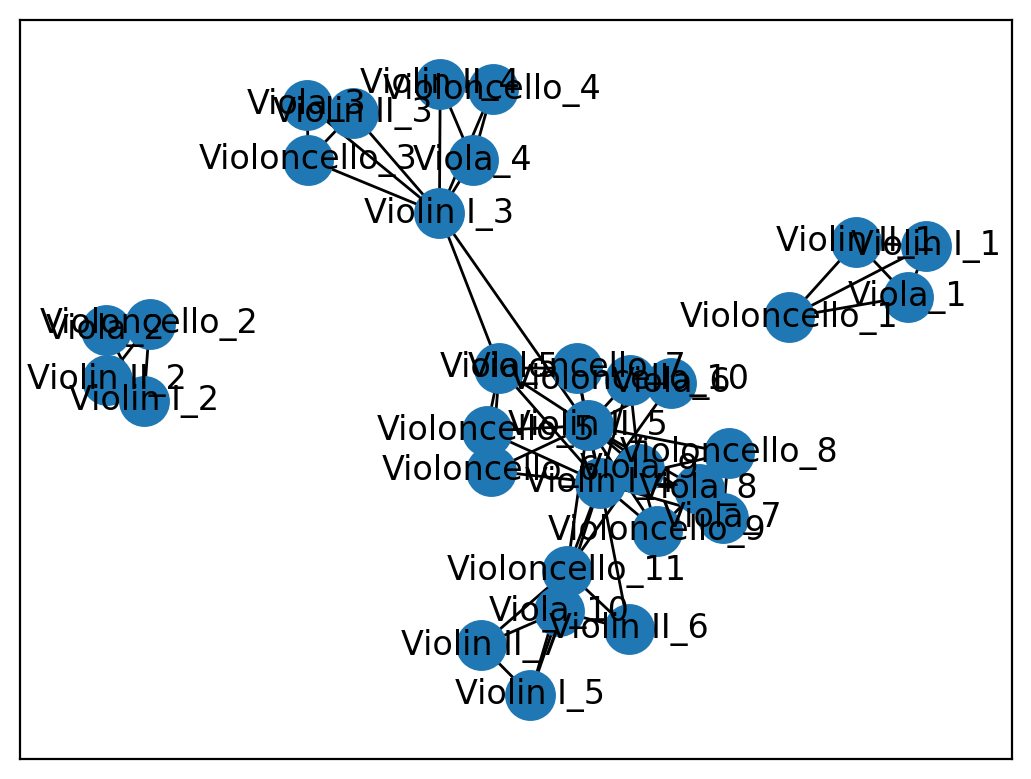

In [5]:
# Create graph

flatStack = [phrase for phrases in phraseStack for phrase in phrases]
uniquePairs = [(i, j) for i in range(len(flatStack)) for j in range(i+1, len(flatStack))]

#print(len(flatStack))
#for p in flatStack: print(p.id, p.entropy)
#for i, j in uniquePairs: print(flatStack[i].id, flatStack[j].id, hasOverlap(flatStack[i], flatStack[j]))

edges = []

for i, j in uniquePairs:
    if hasOverlap(flatStack[i], flatStack[j]):
        edges.append((flatStack[i], flatStack[j]))


SimpleG = nx.Graph()
ObjectG = nx.Graph()

for p in flatStack:
    SimpleG.add_node(p.id)
    ObjectG.add_node(p)

    for n in ObjectG.nodes:
        if p != n and hasOverlap(p, n):
            SimpleG.add_edge(p.id, n.id)
            ObjectG.add_edge(p, n)

#G = defineGraph(edges)
pos = nx.spring_layout(SimpleG, k=0.5) # Force specific layout
nx.draw_networkx(SimpleG, pos=pos)

print(len(SimpleG.edges))

In [7]:
# Solve on QPU

phraseEntropies = [(phrase.id, phrase.entropy + 1) for phrase in flatStack]
bqm = dimod.generators.maximum_weight_independent_set(SimpleG.edges, phraseEntropies, strength_multiplier=2)
print(bqm)

BinaryQuadraticModel({'Violin I_1': -1.0, 'Violin II_1': -1.0, 'Viola_1': -1.0, 'Violoncello_1': -1.0, 'Violin I_2': -4.169925001442312, 'Violin II_2': -2.584962500721156, 'Viola_2': -4.169925001442312, 'Violoncello_2': -4.169925001442312, 'Violin I_3': -5.0, 'Violin II_3': -3.5032583347756456, 'Violin II_4': -1.0, 'Violin II_5': -4.562634418886597, 'Viola_3': -3.5032583347756456, 'Viola_4': -1.0, 'Viola_5': -3.4928786893420307, 'Violoncello_3': -4.169925001442312, 'Violoncello_4': -1.0, 'Violin I_4': -5.75719074674169, 'Violin II_6': -1.0, 'Viola_6': -1.0, 'Viola_7': -1.0, 'Viola_8': -1.0, 'Viola_9': -4.169925001442312, 'Viola_10': -3.2747043575713755, 'Violoncello_5': -1.0, 'Violoncello_6': -1.0, 'Violoncello_7': -1.0, 'Violoncello_8': -1.0, 'Violoncello_9': -1.0, 'Violoncello_10': -1.0, 'Violoncello_11': -5.256662099534205, 'Violin I_5': -4.8079356261755315, 'Violin II_7': -4.8191490723722055}, {('Violin II_1', 'Violin I_1'): 11.51438149348338, ('Viola_1', 'Violin I_1'): 11.51438149

In [ ]:

df = solveWeightedMIS(SimpleG, phraseEntropies, num_reads=1000)

                                              sample     energy  \
0  {'Viola_1': 1, 'Viola_10': 0, 'Viola_2': 0, 'V... -26.821803   
1  {'Viola_1': 0, 'Viola_10': 0, 'Viola_2': 1, 'V... -26.821803   
2  {'Viola_1': 0, 'Viola_10': 0, 'Viola_2': 0, 'V... -26.821803   
3  {'Viola_1': 0, 'Viola_10': 0, 'Viola_2': 0, 'V... -26.821803   
4  {'Viola_1': 0, 'Viola_10': 0, 'Viola_2': 0, 'V... -26.821803   

   num_occurrences  chain_break_fraction  
0                1                   0.0  
1                1                   0.0  
2                1                   0.0  
3                1                   0.0  
4                1                   0.0  
['Viola_1', 'Viola_5', 'Viola_6', 'Viola_8', 'Viola_9', 'Violin II_4', 'Violin II_6', 'Violin II_7', 'Violin I_2', 'Violoncello_3', 'Violoncello_8']
11


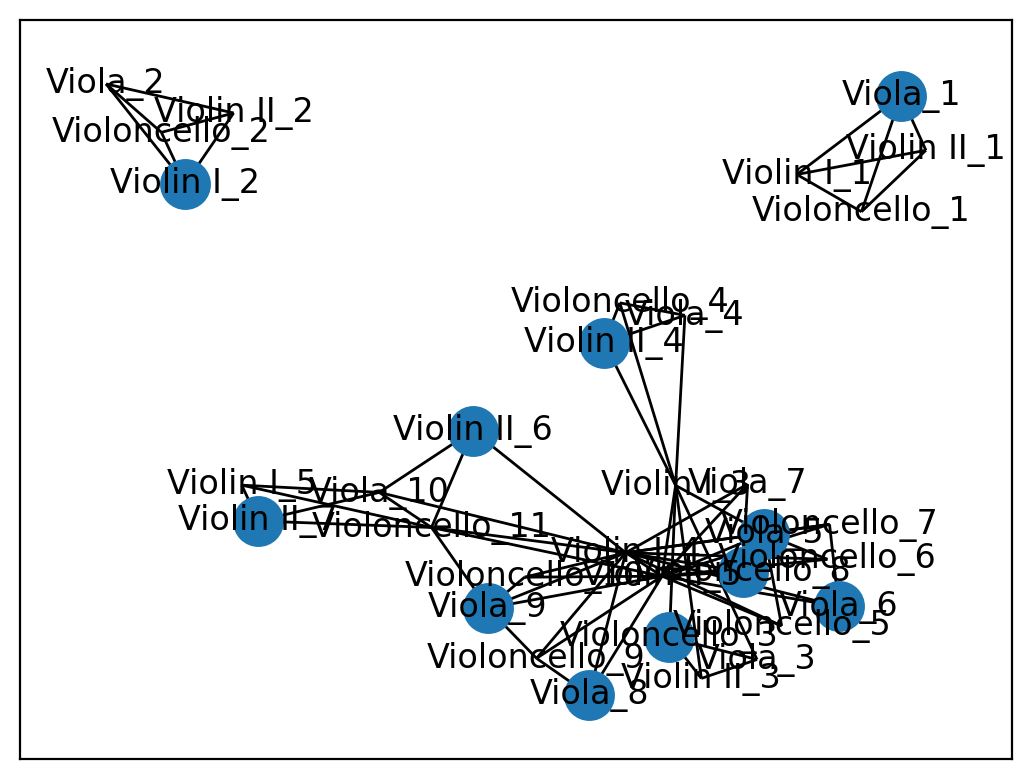

In [39]:
# Show results

print(df.head())
#print(df["energy"].sort_values(ascending=True))

sample = df["sample"][0]
chosen = [x for x in sample if sample[x] == 1]

print(chosen)
print(len(chosen))

nx.draw_networkx(SimpleG, pos=pos, nodelist=chosen)

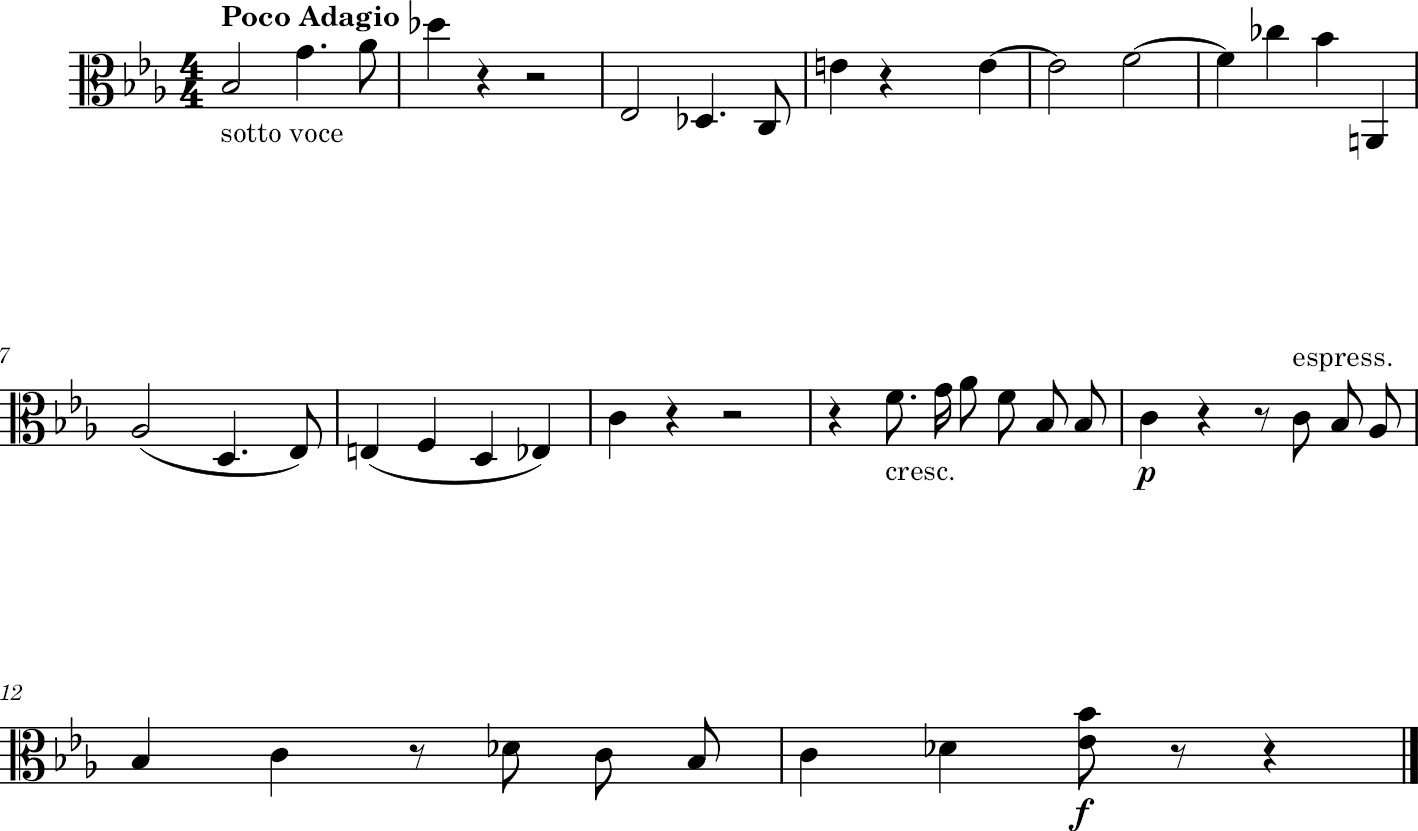

In [36]:
# Final arrangement

arrangement = stream.Stream()

for phrase in flatStack:
    if phrase.id in chosen:
        arrangement.mergeElements(phrase)

arrangement.show()


In [38]:
# Save data

excerpt.write("xml", f"../Pickles/{identifier}_excerpt.xml")
pickle.dump(phraseStack, open(f"../Pickles/{identifier}_phraseStack.pkl", "wb"))
pickle.dump(SimpleG, open(f"../Pickles/{identifier}_simpleGraph.pkl", "wb"))
pickle.dump(ObjectG, open(f"../Pickles/{identifier}_objectGraph.pkl", "wb"))
pickle.dump(df, open(f"../Pickles/{identifier}_df.pkl", "wb"))